# DeepLIFT

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from PIL import Image,ImageFilter

import torch
from transformers import AutoModelForImageClassification, AutoImageProcessor

from captum.attr import DeepLift

#Helper functions
import sys
sys.path.append('../')

from utils.visualise import process_attributions, get_edge, add_edge_to_attributions

## Load images

In [2]:
import sys
sys.path.append('../')

from utils.download import save_image

# Load alternative sample image from the web
url = "https://upload.wikimedia.org/wikipedia/commons/thumb/d/dc/Domestic_Cat_Black_Sitting.jpg/330px-Domestic_Cat_Black_Sitting.jpg"
save_image(url, "cat.png")

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/8/80/A_front_view_of_the_face_of_the_boxer_dog_breed.jpg/330px-A_front_view_of_the_face_of_the_boxer_dog_breed.jpg"
save_image(url, "dog.png")

Figure saved to /Users/conorosullivan/Documents/XAI/deeplift_cat_dog_images.pdf


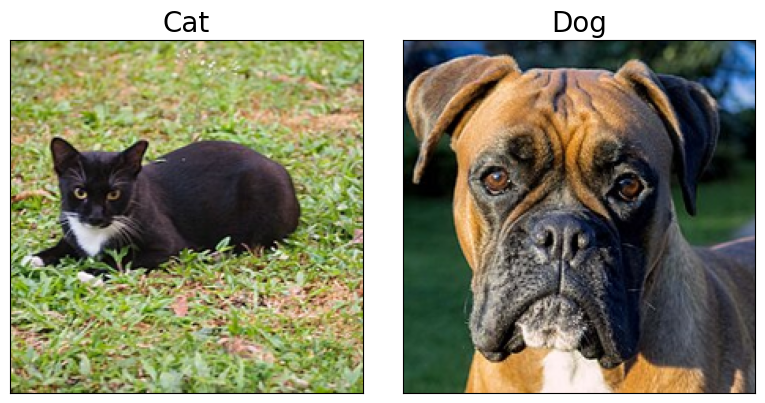

In [3]:
# Update paths
cat_img = Image.open("cat.png")
dog_img = Image.open("dog.png")

fig, ax = plt.subplots(1, 2, figsize=(8, 4))

ax[0].imshow(cat_img)
ax[0].set_title("Cat", size=20)

ax[1].imshow(dog_img)
ax[1].set_title("Dog", size=20)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

## Load model from hugging face

In [4]:
# Load model and processor
model_name = "hilmansw/resnet18-catdog-classifier"
base_model = AutoModelForImageClassification.from_pretrained(model_name)
processor = AutoImageProcessor.from_pretrained(model_name)
base_model.eval()

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/transformers/models/convnext/feature_extraction_convnext.py:30: FutureWarning: The class ConvNextFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ConvNextImageProcessor instead.
  warnings.warn(


ResNetForImageClassification(
  (resnet): ResNetModel(
    (embedder): ResNetEmbeddings(
      (embedder): ResNetConvLayer(
        (convolution): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation): ReLU()
      )
      (pooler): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (encoder): ResNetEncoder(
      (stages): ModuleList(
        (0): ResNetStage(
          (layers): Sequential(
            (0): ResNetBasicLayer(
              (shortcut): Identity()
              (layer): Sequential(
                (0): ResNetConvLayer(
                  (convolution): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                  (normalization): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
                  (activation): ReLU()
           

In [5]:
# Wrap model to return only logits
class WrappedModel(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
    def forward(self, x):
        outputs = self.model(x)
        return outputs.logits  # Captum needs a Tensor output

model = WrappedModel(base_model)
model.zero_grad()

In [6]:
# Load and preprocess images
cat_inputs = processor(images=cat_img, return_tensors="pt",crop_pct=1.0)
dog_inputs = processor(images=dog_img, return_tensors="pt",crop_pct=1.0)

print(cat_inputs['pixel_values'].shape)  # Should be [1, 3, 224, 224]
print(dog_inputs['pixel_values'].shape)  # Should be [1, 3, 224, 224]

torch.Size([1, 3, 224, 224])
torch.Size([1, 3, 224, 224])


In [7]:
# Forward pass
with torch.no_grad():
    logits = model(cat_inputs["pixel_values"])
    predicted_class_idx = logits.argmax(-1).item()

    print("Logits:", logits)
    print(f"Class idx: {predicted_class_idx}")
    print(f"Class:", base_model.config.id2label[predicted_class_idx])

Logits: tensor([[ 7.3466, -7.1000]])
Class idx: 0
Class: cats


## DeepLIFT Attribution

In [8]:
def plot_attributions(input_img,baseline,attr):

    fig, ax = plt.subplots(1, 3, figsize=(10, 4))

    # Input
    ax[0].imshow(input_img)
    ax[0].set_title("Input")

    #Baseline
    ax[1].imshow(baseline)
    ax[1].set_title("Baseline")

    # attribution
    ax[2].imshow(attr)
    ax[2].set_title("DeepLift Attribution")

    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

### Zero baseline

In [9]:
# Initialize DeepLift
deeplift = DeepLift(model)

In [10]:
zero_baseline = np.zeros_like(cat_img)
zero_baseline_tensor = processor(images=zero_baseline, return_tensors="pt",crop_pct=1.0)

# Compute attributions (cat vs zero)
attributions = deeplift.attribute(
    inputs=cat_inputs["pixel_values"],
    baselines=zero_baseline_tensor["pixel_values"],
    target=0
)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


edge value: 255
Figure saved to /Users/conorosullivan/Documents/XAI/deeplift_zero_baseline.pdf


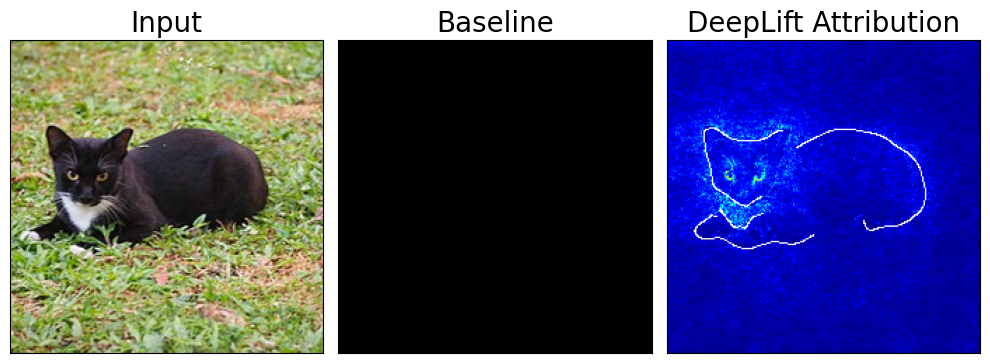

In [11]:
attr = process_attributions(attributions,activation='abs',skew=0.5,colormap='jet')

cat_edge = get_edge(cat_img,h1=0.2,h2=0.3,sigma=5)
attr = add_edge_to_attributions(attr,cat_edge,'white')

baseline = np.zeros((224,224,3))
plot_attributions(cat_img,baseline,attr)

### Mean baseline

In [12]:
# Equivalent to using this tensor
mean_baseline = np.ones_like(cat_img, dtype=np.float32)
for i in range(3):
    mean_baseline[:,:,i] *= [0.485, 0.456, 0.406][i]

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


edge value: 255
Figure saved to /Users/conorosullivan/Documents/XAI/deeplift_mean_baseline.pdf


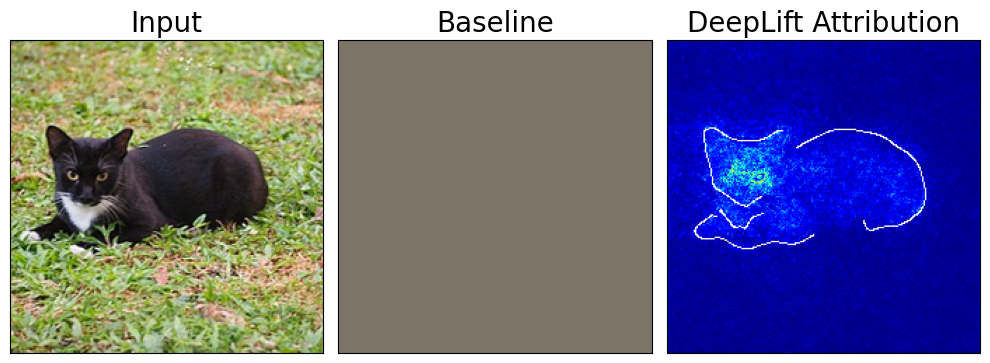

In [13]:
# Mean baseline
attributions = deeplift.attribute(
    inputs=cat_inputs["pixel_values"],
    target=0
)

attr = process_attributions(attributions,activation='abs',skew=0.5,colormap='jet')
attr = add_edge_to_attributions(attr,cat_edge,'white')
plot_attributions(cat_img,mean_baseline,attr)

tensor(0.) tensor(0.)
torch.Size([1, 3, 224, 224])
edge value: 255


/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


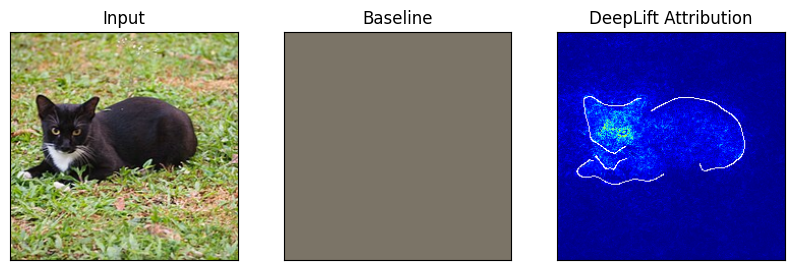

In [14]:
mean_baseline_tensor = processor(images=mean_baseline,
                                 return_tensors="pt",
                                 crop_pct=1.0,
                                 do_rescale=False,
                                 do_resize=False)

pixel_values = mean_baseline_tensor['pixel_values']
print(torch.min(pixel_values),torch.max(pixel_values))
print(pixel_values.shape)

# Compute attributions (cat vs mean)
attributions = deeplift.attribute(
    inputs=cat_inputs["pixel_values"],
    baselines=mean_baseline_tensor['pixel_values'],
    target=0
)

attr = process_attributions(attributions,activation='abs',skew=0.5,colormap='jet')
attr = add_edge_to_attributions(attr,cat_edge,'white')
plot_attributions(cat_img,mean_baseline,attr)

### Blurred baseline

edge value: 255
Figure saved to /Users/conorosullivan/Documents/XAI/deeplift_blurred_baseline.pdf


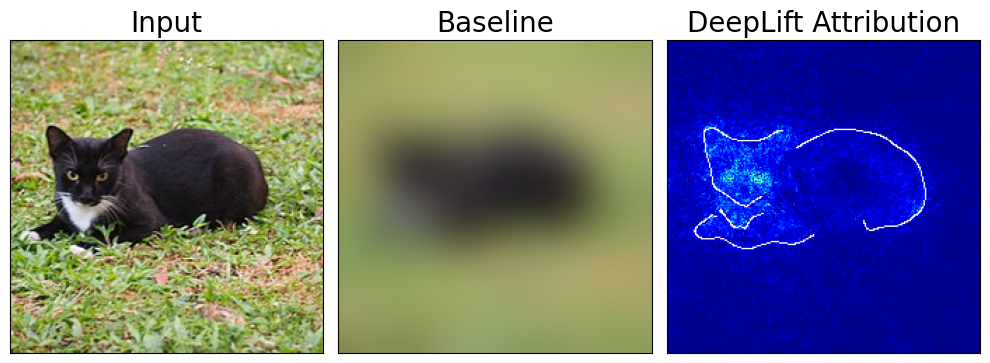

In [15]:
blurred_baseline = cat_img.filter(ImageFilter.GaussianBlur(radius=15))
blurred_baseline_tensor = processor(images=blurred_baseline, return_tensors="pt",crop_pct=1.0)

# Compute attributions (cat vs blurred)
attributions = deeplift.attribute(
    inputs=cat_inputs["pixel_values"],
    baselines=blurred_baseline_tensor["pixel_values"],
    target=0
)

attr = process_attributions(attributions,activation='abs',skew=0.5,colormap='jet')
attr = add_edge_to_attributions(attr,cat_edge,'white')
plot_attributions(cat_img,blurred_baseline,attr)

### Dog baseline

In [16]:
# Initialize DeepLift
deeplift = DeepLift(model,multiply_by_inputs = False)

/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/attr/_core/deep_lift.py:294: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  gradient_mask = apply_gradient_requirements(inputs_tuple)
/Users/conorosullivan/Documents/git/XAI-for-CV/cv_xai_venv/lib/python3.11/site-packages/captum/log/dummy_log.py:39: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  return func(*args, **kwargs)


edge value: 255
edge value: 0
Figure saved to /Users/conorosullivan/Documents/XAI/deeplift_dog_baseline.pdf


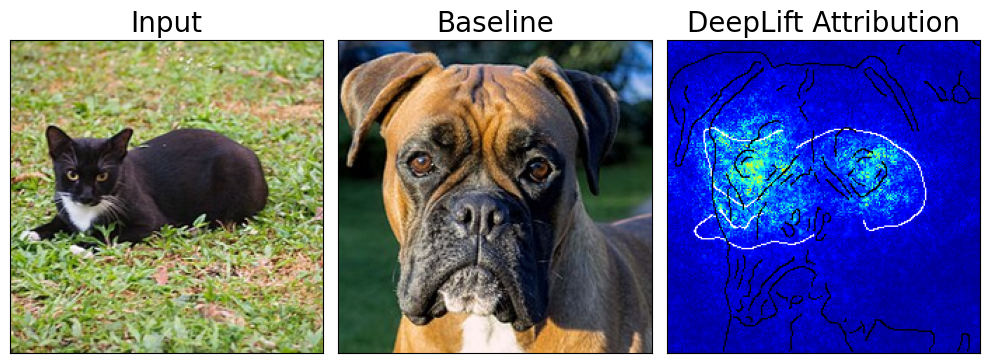

In [17]:
# Compute attributions (cat vs dog)
attributions = deeplift.attribute(
    inputs=cat_inputs["pixel_values"],
    baselines=dog_inputs["pixel_values"],
    target=0
)

# Combine dog and cat edge
dog_edge = get_edge(dog_img,h1=0.3,h2=0.4,sigma=2)
edge = np.clip(cat_edge+dog_edge,0,1)

attr = process_attributions(attributions,activation='abs',skew=0.5,colormap='jet')
attr = add_edge_to_attributions(attr,cat_edge,'white')
attr = add_edge_to_attributions(attr,dog_edge,'black')
plot_attributions(cat_img,dog_img,attr)